# **SIGMA WEDGE CODING CHALLENGE**

*To activate Quantrocket set up the license key*

In [ ]:
from quantrocket.license import set_license
set_license("e7dc7429-dde5-11ee-a0f7-276dcf33ea83")

{'licensekey': 'e7dc........ea83', 'software_license': {}}

In [ ]:
from quantrocket.license import get_license_profile
get_license_profile()

{'licensekey': 'e7dc........ea83', 'software_license': {}}

### **DATA COLLECTION**

*Pulled price data (daily close prices only) for Apple stock (sid='AAPL') for the year 2023 (01-01-2023 to 12-31-2023) from freely available us-stock price data.*

In [ ]:
from quantrocket.master import collect_usstock_listings
collect_usstock_listings()

{'status': 'success', 'msg': 'already up-to-date'}

In [ ]:
from quantrocket.master import get_securities
securities = get_securities(symbols='AAPL', fields=['Sid', 'Symbol', 'Exchange'], vendors='usstock')
securities

,Symbol,Exchange
Sid,,
FIBBG000B9XRY4,AAPL,XNAS


In [ ]:
from quantrocket.zipline import create_usstock_bundle
create_usstock_bundle("aapl-usstock1",free=True)

{'status': 'success', 'msg': 'successfully created aapl-usstock1 bundle'}

In [ ]:
from quantrocket.zipline import ingest_bundle
ingest_bundle("aapl-usstock1")

{'status': 'the data will be ingested asynchronously'}

In [ ]:
from quantrocket import get_prices
data=get_prices('aapl-usstock1', data_frequency='daily', sids="FIBBG000B9XRY4", start_date='2023-01-01', end_date='2023-12-31',fields="Close")

In [ ]:
from quantrocket.zipline import download_bundle_file
download_bundle_file("aapl-usstock1", data_frequency="daily",
                         sids="FIBBG000B9XRY4",
                         start_date="2023-01-01", end_date="2023-12-31",fields="Close",
                         filepath_or_buffer="usstock_aapl.csv")


In [1]:
import pandas as pd
prices=pd.read_csv('usstock_aapl.csv')
prices

,Field,Date,FIBBG000B9XRY4
0,Close,2023-01-03,124.375
1,Close,2023-01-04,125.658
2,Close,2023-01-05,124.325
3,Close,2023-01-06,128.900
4,Close,2023-01-09,129.427
...,...,...,...
245,Close,2023-12-22,193.600
246,Close,2023-12-26,193.050
247,Close,2023-12-27,193.150
248,Close,2023-12-28,193.580


In [2]:
prices.rename(columns = {'FIBBG000B9XRY4':'Stock_price'}, inplace = True)
prices.drop(['Field'],axis=1,inplace=True)
prices

,Date,Stock_price
0,2023-01-03,124.375
1,2023-01-04,125.658
2,2023-01-05,124.325
3,2023-01-06,128.900
4,2023-01-09,129.427
...,...,...
245,2023-12-22,193.600
246,2023-12-26,193.050
247,2023-12-27,193.150
248,2023-12-28,193.580


In [3]:
data=prices

In [4]:
prices.columns

Index(['Date', 'Stock_price'], dtype='object')

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         250 non-null    object 
 1   Stock_price  250 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [6]:
prices.isnull().sum()

Date           0
Stock_price    0
dtype: int64

### **PRE-SPECIFIED LOGIC**

The Class **Stock Trading** Model uses historical stock prices and categorizes it to  daily market states (Bearish,Flat,Bullish) and determines whether to place a buy order trade for the day d+1 in order to maximize the portfolio value

**classify_states**: *Calculates daily returns assigns trading states (1, 0, or -1).*

**find_portfolio**: *Calculating portfolio value and thereby determines optimal buy indices.*

**probability_distribution**: *Computes the probability distribution of state transitions.*

**output**: *Visualizes the probability distribution of different states.*

**predict**: *Provides a simple prediction about buying stock on a given date.*

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class StockTrading:
    def __init__(self, prices):
        self.prices = prices
        self.state=[1]
        self.portfolio=[0]
        self.buy_indices=[]

    def classify_states(self):
        returns=[1]
        close_price=list(self.prices['Stock_price'])
        for i in range(1,len(self.prices)):
            r=((close_price[i]-close_price[i-1])/close_price[i-1])
            returns.append(r)
            if(r>=0.01):
                self.state.append(1)
            elif(r>-0.01):
                self.state.append(0)
            else:
                self.state.append(-1)

    def find_portfolio(self):
        for i in range(1,len(self.state)):
            if self.state[i]==1 and self.state[i-1]==0:
                self.buy_indices.append(i)
                self.portfolio.append(self.portfolio[i-1]+1)
            elif self.state[i]==-1 and self.state[i-1]==0:
                self.portfolio.append(self.portfolio[i-1]-1)
            else:
                self.portfolio.append(self.portfolio[i-1])

    def probability_distribution(self):
        count = {}
        self.classify_states()
        self.find_portfolio()
        for i in range(len(self.state) - 1):
            current_state = self.state[i]
            next_state = self.state[i + 1]
            transition = (current_state, next_state)
            if transition not in count.keys():
                count[transition] = 1
            else:
                count[transition]+= 1
        possible_value=[-1,0,1]
        count_matrix=[]
        for i in possible_value:
            m=[]
            for j in possible_value:
                if (i,j) in count.keys():
                  m.append(count[(i,j)])
                else:
                  m.append(0)
            x=np.array(m)
            s=np.sum(m)
            count_matrix.append(list(x/s))
        #print("P ",portfolio)
        return count_matrix

    def output(self):
        transition_distribution=self.probability_distribution()
        index_names = ['Bear', 'Flat', 'Bull']
        column_names = ['Bear', 'Flat', 'Bull']
        probability_df = pd.DataFrame(transition_distribution, index=index_names, columns=column_names)
        plt.figure(figsize=(8, 6))
        sns.heatmap(probability_df, annot=True, cmap='Blues', fmt=".3f", linewidths=.5)
        plt.title('Probability Distribution')
        plt.xlabel('Next State')
        plt.ylabel('Previous State')
        plt.show()
        dates=[]
        for i in self.buy_indices:
          dates.append(self.prices.iloc[i]['Date'])
        print("PORTFOLIO VALUE V(N) : ",self.portfolio[-1])
        print("OPTIMAL BUY INDICES : ",self.buy_indices)
        print("BUY DATES : ", dates)

    def predict(self,date):
      if(self.state[-2]==0 and self.state[-1]==1):
        print("You can buy the stock on ",date)
      else:
        print("You can't buy the stock on ",date)

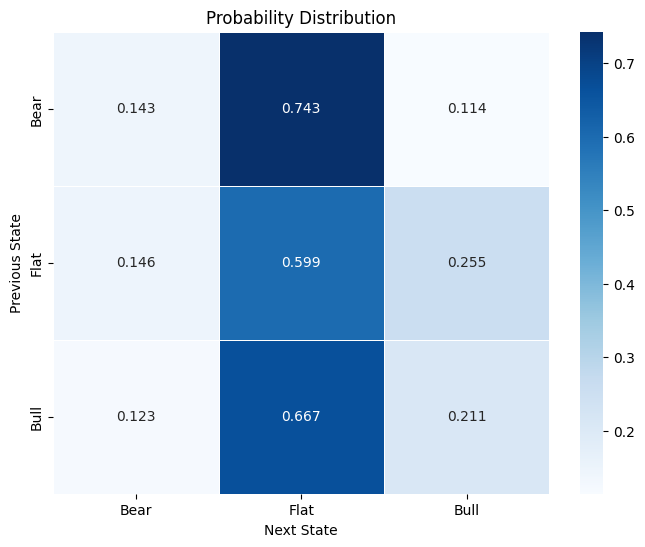

PORTFOLIO VALUE V(N) :  17
OPTIMAL BUY INDICES :  [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
BUY DATES :  ['2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-12-13']


In [8]:
end_of_day_price = StockTrading(prices)
end_of_day_price.output()

### **DATA AND PLOTS**

Stock Closing price vs Date

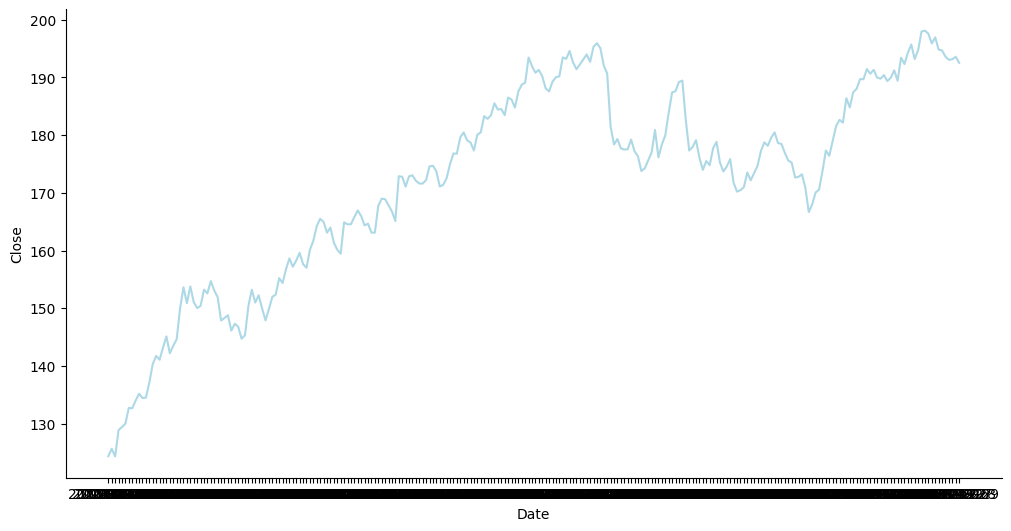

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
lightblue_rgb = (173/255, 216/255, 230/255)
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))

  xs = prices['Date']
  ys = prices['Stock_price']

  plt.plot(xs, ys, label=series_name, color=lightblue_rgb)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = prices.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

Histograms of Daily Returns

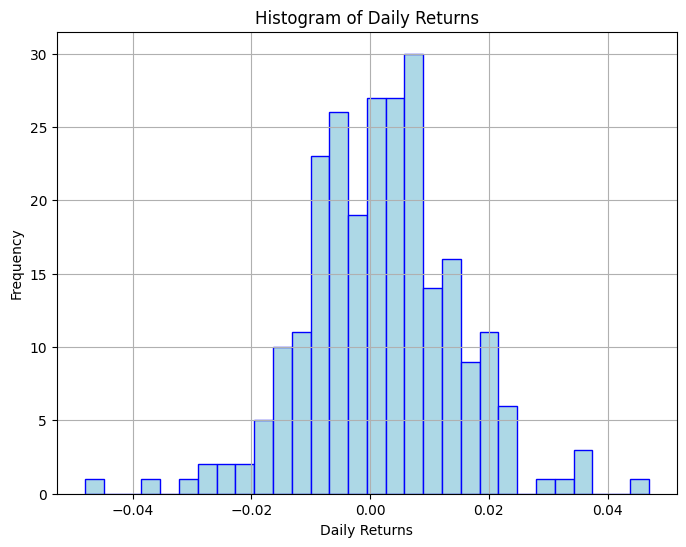

In [37]:
# Calculate daily returns
daily_returns = prices['Stock_price'].pct_change().dropna()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=30, color=lightblue_rgb, edgecolor="blue")
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### **TIME SERIES FORECASTING**

In [9]:
df=prices

**Checking Components of Time Series**

*From the belong plot we can clearly see that there increasing positive Trend and no Seasonality and Residuals*

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def component_analysis(df,data):
  if(df.isnull().any().any()):
    df=df.dropna()
  result = seasonal_decompose(data, model='additive', period=1)

  plt.figure(figsize=(12, 8))

  # ORIGINAL DATA
  plt.subplot(4, 1, 1)
  plt.plot(df.index, data, label='Original')
  plt.legend(loc='upper left')
  plt.title('Original Time Series')
  plt.xticks([])

  # TREND COMPONENT
  plt.subplot(4, 1, 2)
  plt.plot(df.index, result.trend, label='Trend')
  plt.legend(loc='upper left')
  plt.title('Trend Component')
  plt.xticks([])

  # SEASONALITY COMPONENT
  plt.subplot(4, 1, 3)
  plt.plot(df.index, result.seasonal, label='Seasonality')
  plt.legend(loc='upper left')
  plt.title('Seasonality Component')
  plt.xticks([])

  # RESIDUALS
  plt.subplot(4, 1, 4)
  plt.plot(df.index, result.resid, label='Residuals')
  plt.legend(loc='upper left')
  plt.title('Residuals')
  plt.xticks([])

  plt.tight_layout()
  plt.show()


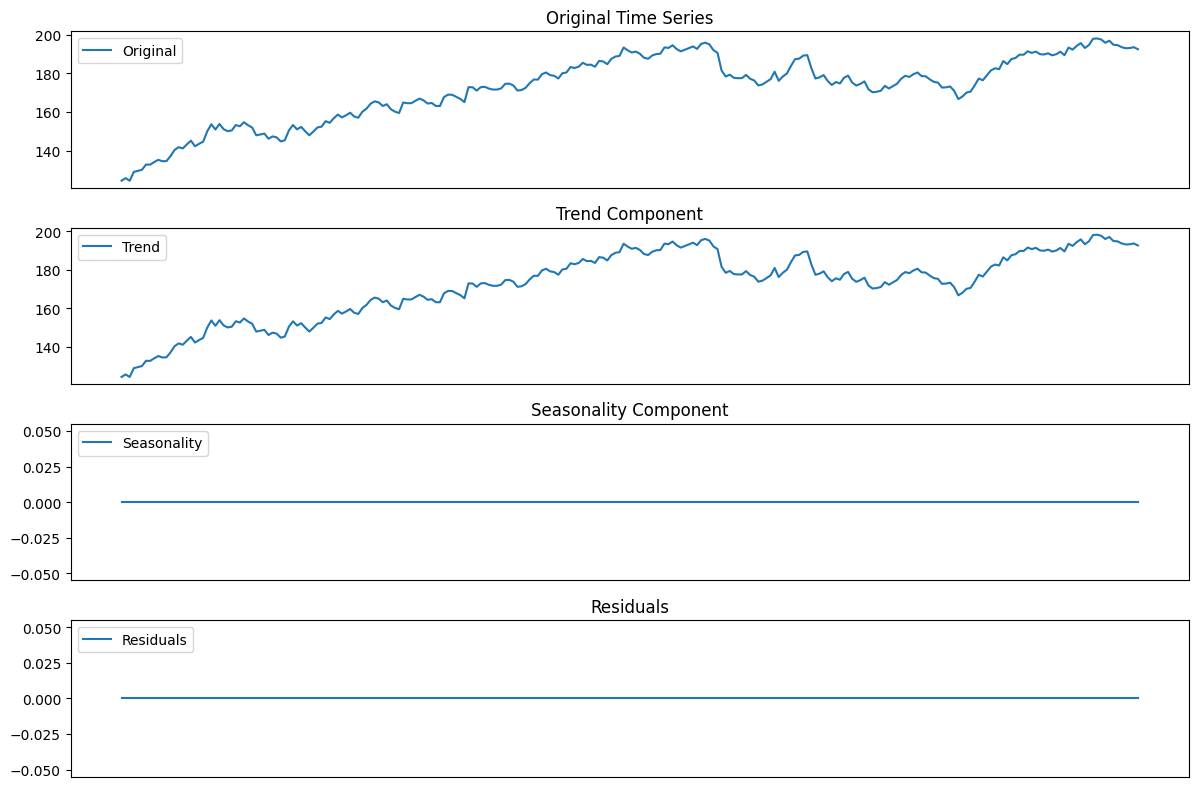

In [ ]:
component_analysis(df,df['Stock_price'])

**Test stationery**

In [11]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")

def kpss_test(data):
  result = kpss(data, regression='c')
  print("KPSS Statistic:", result[0])
  print("p-value:", result[1])
  print("Critical Values:", result[3])
  print('\n')
  if result[1] < 0.05:
      print("The time series is not stationary (reject the null hypothesis)")
  else:
      print("The time series is stationary (fail to reject the null hypothesis)")

In [12]:
kpss_test(df['Stock_price'])

KPSS Statistic: 1.7159551343844486
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


The time series is not stationary (reject the null hypothesis)


*p-value of (Kwiatkowski–Phillips–Schmidt–Shin) KPSS test resulting to be 0.01 which comes out to be less than significance level of 0.05 thereby rejecting the Null Hypothesis.This states that the data is non stationary*

In [13]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
  result = adfuller(data,autolag='AIC')
  print("ADF Statistic:", result[0])
  print("p-value:", result[1])
  print("Critical Values:", result[4])
  print('\n')
  if result[1] <=0.05:
      print("The time series is stationary (reject the null hypothesis)")
  else:
      print("The time series is not stationary (fail to reject the null hypothesis)")


In [14]:
adfuller_test(df['Stock_price'])

ADF Statistic: -2.5861110326138066
p-value: 0.09590194595133555
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}


The time series is not stationary (fail to reject the null hypothesis)


*p-value of Dickey Fuller test resulting to be 0.09 which comes out to be greater than significance level of 0.05 thereby rejecting the Null Hypothesis.This states that the data is non stationary*

### **ARIMA**

*Better Model to forecast data with trend and no seasonality comes up to be ARIMA*

**Differencing Data** : *Differencing of the time series data to make the non-stationary data into stationary data.*

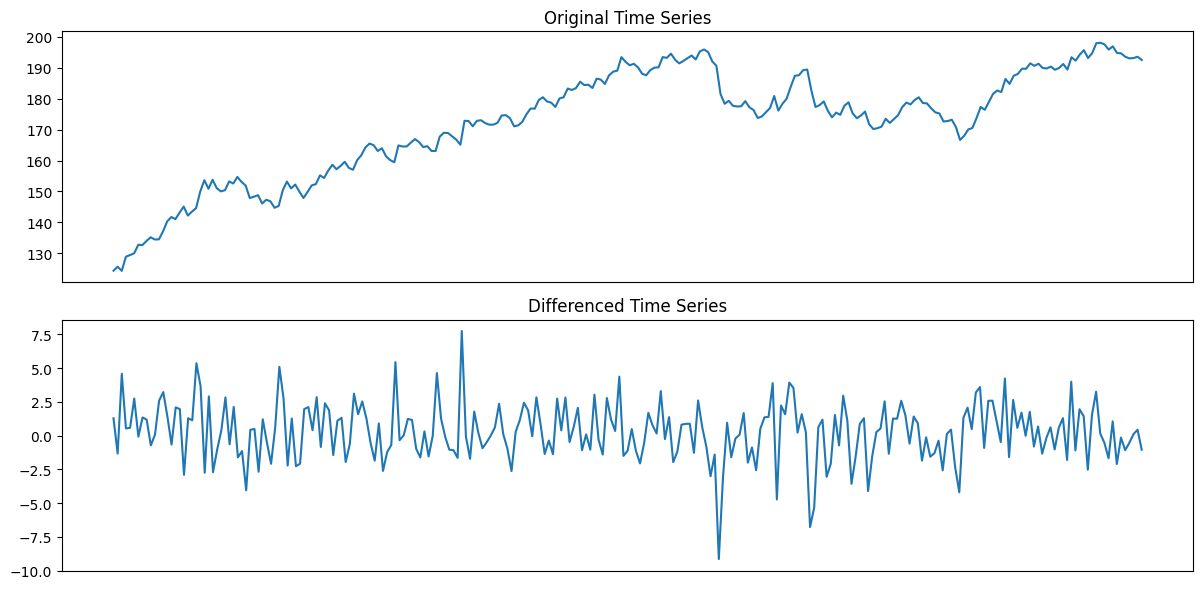

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df['Stock_price'])
plt.title('Original Time Series')
plt.xticks([])

differenced= df['Stock_price'].diff().dropna()

plt.subplot(2, 1, 2)
plt.plot(differenced)
plt.title('Differenced Time Series')
plt.xticks([])

plt.tight_layout()
plt.show()

**Checking for stationery after differencing**

In [16]:
kpss_test(differenced)

KPSS Statistic: 0.2560725802772843
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


The time series is stationary (fail to reject the null hypothesis)


*Thus at the First Order Differencing the data becomes stationary.*

**Ploting ACF(Auto Correlation Function)** : *To find the significant value of q in ARIMA*

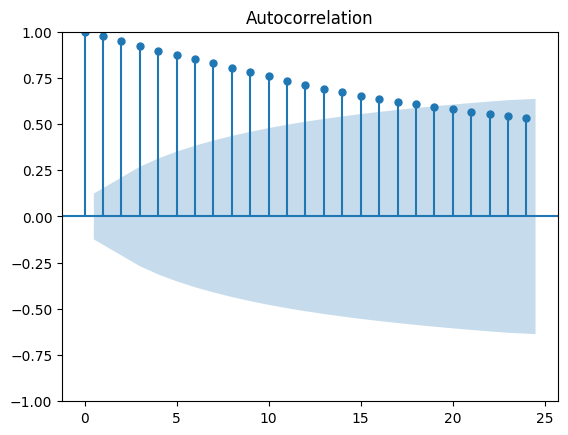

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Stock_price'])
plt.show()

**Ploting PACF(Partial Auto Correlation Function)** : *To find the significant value of p in ARIMA*

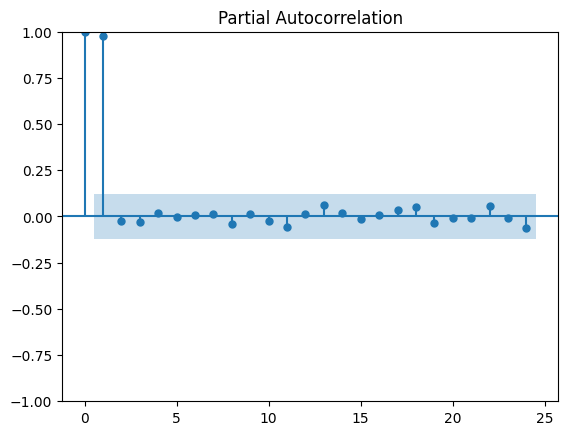

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Stock_price'])
plt.show()

**ARIMA MODEL**

**Parameters of ARIMA Model(p,d,q) :**(1,1,18)


In [19]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

In [20]:
X = df['Stock_price'].values

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,18))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
#print(predictions)

predicted=182.303998, expected=187.403000
predicted=188.108668, expected=187.623000
predicted=186.536458, expected=189.211000
predicted=188.028443, expected=189.450000
predicted=189.798631, expected=182.669000
predicted=182.270050, expected=177.326000
predicted=178.193353, expected=177.946000
predicted=178.104254, expected=179.124000
predicted=182.661783, expected=176.068000
predicted=177.205262, expected=173.981000
predicted=175.153938, expected=175.509000
predicted=173.873050, expected=174.780000
predicted=171.466133, expected=177.736000
predicted=177.566031, expected=178.834000
predicted=175.915413, expected=175.259000
predicted=175.762972, expected=173.701000
predicted=173.420708, expected=174.560000
predicted=173.476517, expected=175.848000
predicted=175.834742, expected=171.734000
predicted=170.935627, expected=170.206000
predicted=172.617233, expected=170.465000
predicted=173.223599, expected=170.985000
predicted=172.065037, expected=173.521000
predicted=172.645749, expected=172

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.347


*Thus when predicting with built ARIMA model the RMSE value comes out to be 2.347*

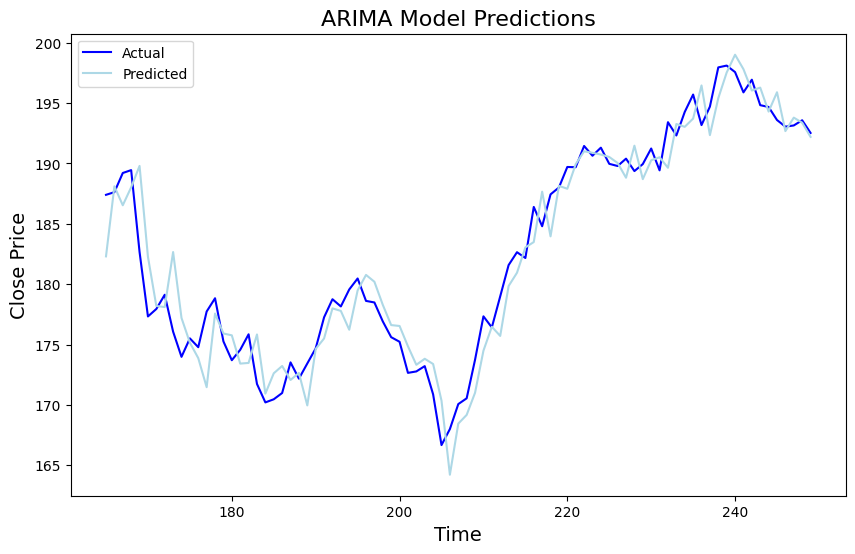

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(size, len(X)), test, color='blue', label='Actual')
plt.plot(range(size, len(X)), predictions, color=lightblue_rgb, label='Predicted')
plt.title('ARIMA Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.show()

**Making Stock Trading Decisions (on certain days)**


*From the last date of dataset starts forecasting till the given date thus calculating no of steps to forescast.*

*Results in forecating the stock closing price of that given date to make decision on whether to place a buy order trade or not.*

In [22]:
from datetime import datetime, timedelta
def get_day_of_week(date_string):
    try:
        day_of_week = date_string.weekday()
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_name = days[day_of_week]
        return day_name
    except ValueError:
        return "Invalid date format. Please provide date in YYYY-MM-DD format."

In [23]:
def no_of_days(given_date):
    start_date=datetime(2023, 12, 29)
    if get_day_of_week(given_date)=='Saturday' or get_day_of_week(given_date)=='Sunday':
      return 0
    elif given_date<start_date:
      return -1
    else:
      current_date=start_date+timedelta(days=1)
      days=0
      dates = []
      while current_date<given_date:
          if current_date.weekday() < 5:
              days += 1
              dates.append(current_date.strftime('%Y-%m-%d'))
          current_date+=timedelta(days=1)
      return days,dates

In [24]:
def arima(data,count):
  X = df['Stock_price'].values
  train = X
  history = [x for x in train]
  predictions = list()
  model = ARIMA(history, order=(1,1,18))
  model_fit = model.fit()
  output = model_fit.forecast(steps=count)
  return output

          Date  Stock_price
0   2024-01-01   192.138310
1   2024-01-02   191.461618
2   2024-01-03   191.697334
3   2024-01-04   192.438136
4   2024-01-05   191.699032
5   2024-01-08   190.986888
6   2024-01-09   191.024686
7   2024-01-10   191.371375
8   2024-01-11   191.842920
9   2024-01-12   191.630430
10  2024-01-15   191.967837
11  2024-01-16   191.664073
12  2024-01-17   192.166478
13  2024-01-18   191.952798
14  2024-01-19   192.223375
15  2024-01-22   192.106210
16  2024-01-23   192.111133
17  2024-01-24   192.078740
18  2024-01-25   192.099789
19  2024-01-26   192.086111
20  2024-01-29   192.094999
21  2024-01-30   192.089224
22  2024-01-31   192.092977
23  2024-02-01   192.090538
24  2024-02-02   192.092123
25  2024-02-05   192.091093
26  2024-02-06   192.091762
27  2024-02-07   192.091327
28  2024-02-08   192.091610
29  2024-02-09   192.091426
30  2024-02-12   192.091545
31  2024-02-13   192.091468
32  2024-02-14   192.091518
33  2024-02-15   192.091486
34  2024-02-16   192

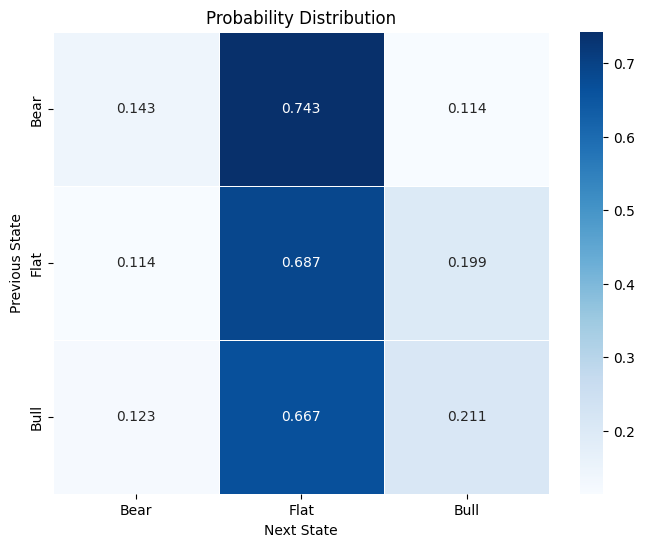

PORTFOLIO VALUE V(N) :  17
OPTIMAL BUY INDICES :  [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]
BUY DATES :  ['2023-01-11', '2023-01-13', '2023-01-20', '2023-01-26', '2023-02-02', '2023-02-13', '2023-02-15', '2023-03-03', '2023-03-16', '2023-03-20', '2023-03-29', '2023-03-31', '2023-04-13', '2023-04-27', '2023-05-05', '2023-05-10', '2023-05-18', '2023-05-26', '2023-06-01', '2023-06-08', '2023-06-12', '2023-06-15', '2023-06-22', '2023-06-27', '2023-06-30', '2023-07-17', '2023-07-28', '2023-08-23', '2023-08-29', '2023-09-18', '2023-10-02', '2023-10-06', '2023-10-30', '2023-11-01', '2023-11-06', '2023-11-10', '2023-11-14', '2023-12-05', '2023-12-07', '2023-12-13']


You can't buy the stock on  2024-03-01


In [40]:
given_date = datetime(2024,3,1)    #input date(can give any date)
count,dates=no_of_days(given_date)
formatted_date = given_date.strftime("%Y-%m-%d")

if(count==0):
  print("Stocks cannot be bought on "+get_day_of_week(given_date))
elif(count==-1):
  print("Given past date.Provide a valid date")
else:
  result=arima(data,count)
  forecast_df = pd.DataFrame({'Date': dates, 'Stock_price': result})
  print(forecast_df)
  frames = [data, forecast_df]
  data1 = pd.concat(frames)
  predicted=StockTrading(data1)
  predicted.output()
  print('\n')
  predicted.predict(formatted_date)
